<a href="https://colab.research.google.com/github/nehagovekar/Natural-Language-Processing/blob/main/Neha_file1_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align='center'><b><font color='indianred'></p>Spam Detection HW</b></h1>

<font color = 'indianred' size = 4 >**Read complete instructions before starting the HW** </font>


# <font color='indianred'> **Q1: Load the dataset  (1 Point)**

- For this Hw you will usespam dataset from kaggle which can be found from [this](https://www.kaggle.com/uciml/sms-spam-collection-dataset) link. You can download this data and either upload it in google drive or in colab workspace. Load the data in pandas dataframe.

- There are only two useful columns. These columns are related to (1) label (ham and spam) and the (2) text of email.

- Rename columns as label and message

- Find the %  ham amd spam in the data.





In [1]:
import joblib
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import f1_score, make_scorer
from xgboost import XGBClassifier
import spacy
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin, BaseEstimator
from scipy.sparse import csr_matrix
from sklearn.metrics import classification_report

In [2]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    !pip install -U nltk -qq
    !pip install -U spacy -qq
    !python -m spacy download en_core_web_sm -qq



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 63.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
from google.colab import files

uploaded = files.upload()

Saving spam.csv to spam (2).csv


In [4]:
df=pd.read_csv('spam.csv',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
df=df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
#Rename the columns
df.columns=['label','message']
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
#count the number of ham and spam labels
df['label'].value_counts()

,count
label,
ham,4825
spam,747


In [8]:
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

SMALLER SUBSET OF DATA

In [9]:
subset_data=  df.sample(frac=0.1, replace=True, random_state=1)

In [10]:
subset_data.head()

,label,message
5157,0,K k:) sms chat with me.
235,0,I have printed it oh. So &lt;#&gt; come upst...
3980,0,Huh i cant thk of more oredi how many pages do...
5192,0,Oh oh... Den muz change plan liao... Go back h...
905,0,Hey what's up charles sorry about the late reply.


In [11]:
X_train, X_test, y_train, y_test = train_test_split(subset_data['message'], subset_data['label'], test_size=0.2, random_state=42)

# <font color='indianred'> **Q2 : Provide the metric for evaluating model (1 Point)**</font>

As you will notice, the  data is highly imbalanced (most messages are labelled as ham and only few are labelled as spam). Always predicting ham will give us very good accuracy (close to 90%). So you need to choose a different metric.

Task: Provde the metric you will choose to evaluate your model. Explain why this is an appropriate metric for this case.

**I would go with F1 score, because it balances recall and precision and gives us a good understanding of how the model is evaluating the minority class which here is spam class.**

# <font color='indianred'> **Q3 : Classification Pipelines (18 Points)**</font>

In the previous lectures you learned Data processing, Featurization such as CountVectorizer, TFIDFVectorizer, and also Feature Engineering.
* You will now use folllowing methods to create fearures which you can use in your model.

    1. Sparse Embeddings (TF-IDF) (6 Points)
    2. Feature Engineering (see examples below) (6 Points)
    3. Sparse Embeddings (TF-IDF) + Feature Engineering (6 Points)

**Approach:**

<font color='indianred'> ****Use a smaller subset of dataset (e.g. 5-10 %) to evaluate the three pipelines . Based on your analysis (e.g. model score, learning curves) , choose one pipeline from the three. Provde your rational for choosing the pipleine. Train only the final pipeline on randomly selected larger subset (e.g. 40%) of the data.** </font>

**Requirements:**

1. You can use any ML model (Logistic Regression, XgBoost) for the classification. You will need to tune the **model for imbalanced dataset** (The link on XGBoost tutorial for imbalanced data: https://machinelearningmastery.com/xgboost-for-imbalanced-classification/).

2. For feature engineering, you can choose from the examples below. You do not  have to use all of them. You can add other featues as well. Think about what faetures can distinguish a spam from a regular email. Some examples :

>> Count of following  (Words, characters, digits, exclamation marks, numbers, Nouns, ProperNouns, AUX, VERBS, Adjectives, named entities, spelling mistakes (see the link on how to get spelling mistakes https://pypi.org/project/pyspellchecker/).

3. For Sparse embeddings you will use **tfidf vectorization**. You need to choose appopriate parameters e.g. min_df, max_df, max_faetures, n-grams etc.).

4. Think carefully about the pre-processing you will do.

5. Make sure to modify the plot learning curve code to incorporate apprioparite metric. The default is accuracy which may noit be a good choice.

Tip: <font color = 'indianred'>**Using GridSearch for hyperparameter tuning might take a lot of time. Try using RandomizedSearch.**</font> You can also explore faster implementation of Gridsearch and RandomizedSearch in sklearn:

1. [Halving Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html?highlight=halving#sklearn.model_selection.HalvingGridSearchCV)

2. [HalvingRandomSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html?highlight=halving#sklearn.model_selection.HalvingRandomSearchCV)





## <font color ='pickle'>**Pipeline 1: Data Preprocessing + Sparse Embeddings (TF-IDF) + ML Model**





In [12]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Custom')
import CustomPreprocessorSpacy as cp
from CustomPreprocessorSpacy import SpacyPreprocessor  # Custom preprocessing

In [13]:
import os
print(os.listdir('/content/drive/My Drive/Colab Notebooks/Custom'))

['CustomPreprocessorSpacy.py', '__pycache__', 'plot_learning_curve.py', 'FeaturizerSpacy.py']


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

In [15]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Custom')
from plot_learning_curve import plot_learning_curve

In [16]:
cp.SpacyPreprocessor??

In [17]:
X_train_list = X_train.tolist()
X_train_cleaned_bow = cp.SpacyPreprocessor(model='en_core_web_sm', batch_size = 500).transform(X_train_list)

/content/drive/My Drive/Colab Notebooks/Custom/CustomPreprocessorSpacy.py:83: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [18]:
X_test_list = X_test.tolist()
X_test_cleaned_bow = cp.SpacyPreprocessor(model='en_core_web_sm', batch_size = 500).transform(X_test_list)

In [19]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the pipeline
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', XGBClassifier(random_state=42))
])

# Define the parameter grid for XGBoost
param_grid_xgb = {
    'vectorizer__max_features': [1000, 2000, 5000],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 4, 5, 6],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.8, 0.9, 1.0],
    'classifier__scale_pos_weight': [1, 5, 10, 20],
    'classifier__gamma': [0, 0.1, 0.2, 0.3],
    'classifier__reg_alpha': [0, 0.1, 1, 10],
    'classifier__reg_lambda': [1, 1.5, 2, 3]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid_xgb,
                                   n_iter=10, scoring='f1', cv=3, n_jobs=-1, random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print best parameters and score
print(f'Best cross-validation score: {random_search.best_score_:.2f}')
print("\nBest parameters: ", random_search.best_params_)
print("\nBest estimator: ", random_search.best_estimator_)


Best cross-validation score: 0.74

Best parameters:  {'vectorizer__max_features': 1000, 'classifier__subsample': 1.0, 'classifier__scale_pos_weight': 20, 'classifier__reg_lambda': 2, 'classifier__reg_alpha': 0.1, 'classifier__n_estimators': 200, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.1, 'classifier__gamma': 0.2, 'classifier__colsample_bytree': 0.9}

Best estimator:  Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=1000)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0.2, grow_policy=None,
                               importance_type=None,
                       

In [20]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, f1_score

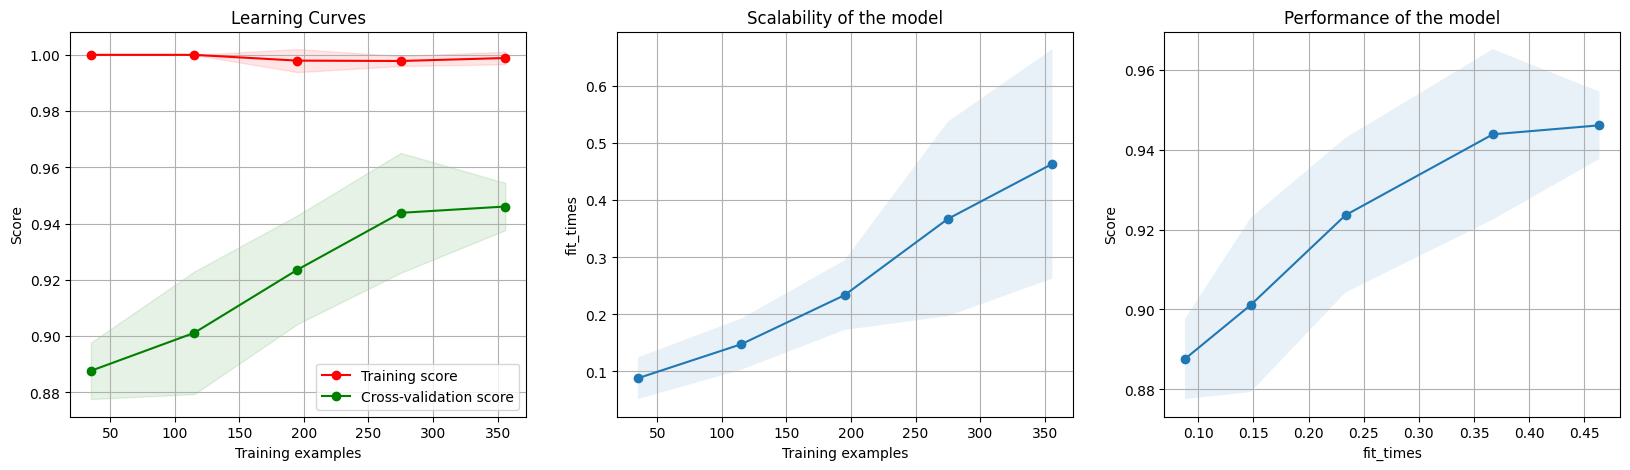

In [21]:
plot_learning_curve(random_search.best_estimator_, 'Learning Curves',
                    X_train_cleaned_bow, y_train, n_jobs=-1)
plt.show()

**Evaluate Model on Test Dataset**

In [22]:
# Final Pipeline
def final_pipeline(text):
    # cleaned_text = cp.SpacyPreprocessor(model='en_core_web_sm').transform(text)
    cleaned_text = X_test_cleaned_bow
    best_estimator_pipeline1_round1 = random_search.best_estimator_
    predictions = best_estimator_pipeline1_round1.predict(cleaned_text)
    return predictions

In [23]:
# predicted values for Test data set
y_test_pred = final_pipeline(X_test)

**Classification Report on Test Dataset**

In [24]:
print('\nTest set classification report:\n\n',
      classification_report(y_test, y_test_pred))


Test set classification report:

               precision    recall  f1-score   support

           0       0.89      1.00      0.94        98
           1       1.00      0.14      0.25        14

    accuracy                           0.89       112
   macro avg       0.95      0.57      0.60       112
weighted avg       0.90      0.89      0.86       112



## <font color ='pickle'>**Pipeline 2:  Feature Engineering + ML Model pipeline**

In [25]:
X_train_list = X_train.tolist()
X_train_cleaned_basic = cp.SpacyPreprocessor(model='en_core_web_sm',
                                                    lemmatize=False, lower=False,
                                                    remove_stop=False, remove_punct=False,
                                                    remove_email=False, remove_url=False,
                                                     add_user_mention_prefix=False,
                                                     basic_clean_only=True).transform(X_train_list)

/content/drive/My Drive/Colab Notebooks/Custom/CustomPreprocessorSpacy.py:83: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [26]:
X_test_list = X_test.tolist()
X_test_cleaned_basic = cp.SpacyPreprocessor(model='en_core_web_sm',
                                                    lemmatize=False, lower=False,
                                                    remove_stop=False, remove_punct=False,
                                                    remove_email=False, remove_url=False,
                                                     add_user_mention_prefix=False,
                                                     basic_clean_only=True).transform(X_test_list)

In [27]:
from FeaturizerSpacy import ManualFeatures
featurizer = ManualFeatures(spacy_model='en_core_web_sm', batch_size = 1000)

In [28]:
X_train_features, feature_names = featurizer.fit_transform(X_train_cleaned_basic)

In [29]:
X_train_features[0:3]

array([[19.    , 89.    , 72.    ,  3.6   ,  1.    ,  4.    ,  5.    ,
         0.    ,  6.    ,  1.    ,  1.    ],
       [ 9.    , 43.    , 35.    ,  3.5   ,  1.    ,  1.    ,  3.    ,
         0.    ,  1.    ,  0.    ,  1.    ],
       [15.    , 67.    , 53.    ,  3.3125,  0.    ,  1.    ,  3.    ,
         1.    ,  3.    ,  1.    ,  0.    ]])

In [30]:
feature_names

['count_words',
 'count_characters',
 'count_characters_no_space',
 'avg_word_length',
 'count_numbers',
 'count_sentences',
 'noun_count',
 'aux_count',
 'verb_count',
 'adj_count',
 'ner']

In [31]:
# Your data is numeric, so no vectorization step is needed
pipeline = Pipeline([
    ('classifier', LogisticRegression(max_iter=10000))
])

# Param grid (as you already have)
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'classifier__max_iter': [100, 200, 500],
    'classifier__class_weight': [None, 'balanced'],
}

# Randomized search with the corrected pipeline
random_search = RandomizedSearchCV(pipeline, param_grid, n_iter=10, cv=5, random_state=42)

# Fit the model
random_search.fit(X_train_features, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: Futur

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('classifier',
                                              LogisticRegression(max_iter=10000))]),
                   param_distributions={'classifier__C': [0.001, 0.01, 0.1, 1,
                                                          10, 100],
                                        'classifier__class_weight': [None,
                                                                     'balanced'],
                                        'classifier__max_iter': [100, 200, 500],
                                        'classifier__penalty': ['l1', 'l2',
                                                                'elasticnet',
                                                                'none']},
                   random_state=42)

In [32]:
# Print best parameters and score
print(f'Best cross-validation score: {random_search.best_score_:.2f}')
print("\nBest parameters: ", random_search.best_params_)
print("\nBest estimator: ", random_search.best_estimator_)

Best cross-validation score: 0.94

Best parameters:  {'classifier__penalty': 'l2', 'classifier__max_iter': 100, 'classifier__class_weight': None, 'classifier__C': 10}

Best estimator:  Pipeline(steps=[('classifier', LogisticRegression(C=10))])


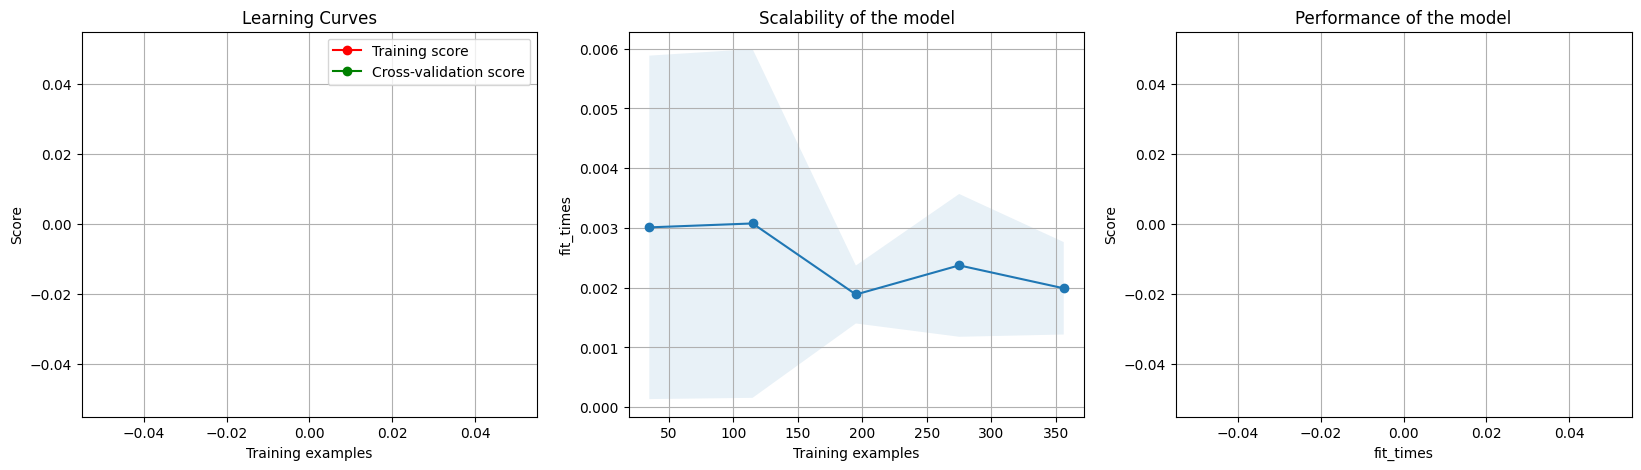

In [33]:
plot_learning_curve(random_search.best_estimator_, 'Learning Curves',
                    X_train_cleaned_basic, y_train, n_jobs=-1)
plt.show()

**Evaluate model on test dataset**

In [34]:
# Final Pipeline
def final_pipeline(text):
    text_cleaned = (X_test_cleaned_basic)
    features, feature_names = featurizer.fit_transform(text_cleaned)
    best_estimator_pipeline2_round1 = random_search.best_estimator_

    predictions = best_estimator_pipeline2_round1.predict(features)
    return predictions

In [35]:
# predicted values for Test data set
y_test_pred = final_pipeline(X_test)

In [36]:
print('\nTest set classification report:\n\n',
      classification_report(y_test, y_test_pred))


Test set classification report:

               precision    recall  f1-score   support

           0       0.95      0.97      0.96        98
           1       0.75      0.64      0.69        14

    accuracy                           0.93       112
   macro avg       0.85      0.81      0.83       112
weighted avg       0.92      0.93      0.93       112



## <font color ='pickle'>**Pipeline 3:  Sparse Embeddings (TF-IDF) + Feature Engineering **

In [37]:
X_train_list = X_train.tolist()
X_train_cleaned_bow = cp.SpacyPreprocessor(model='en_core_web_sm', batch_size = 500).transform(X_train_list)

/content/drive/My Drive/Colab Notebooks/Custom/CustomPreprocessorSpacy.py:83: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [38]:
X_train_final = pd.concat((pd.DataFrame(X_train_cleaned_bow, columns=['cleaned_text']),
                           pd.DataFrame(X_train_features, columns=feature_names)), axis=1)

In [39]:
X_train_final.head()

,cleaned_text,count_words,count_characters,count_characters_no_space,avg_word_length,count_numbers,count_sentences,noun_count,aux_count,verb_count,adj_count,ner
0,desires- u go doctor 4 liver bit stylish ur ha...,19.0,89.0,72.0,3.600000,1.0,4.0,5.0,0.0,6.0,1.0,1.0
1,oh thank lot buy 2 egg,9.0,43.0,35.0,3.500000,1.0,1.0,3.0,0.0,1.0,0.0,1.0
2,iû÷ve get salt rub open wound like,15.0,67.0,53.0,3.312500,0.0,1.0,3.0,1.0,3.0,1.0,0.0
3,wait e car dat bored wat cos wait outside get ...,28.0,117.0,92.0,3.172414,1.0,3.0,8.0,2.0,6.0,1.0,1.0
4,ok go to head usf like minute,13.0,51.0,41.0,2.928571,0.0,1.0,1.0,1.0,3.0,0.0,1.0


In [40]:
class SparseTransformer(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return csr_matrix(X)

In [41]:
sparse_features = Pipeline([('sparse', SparseTransformer()), ])
vectorizer = Pipeline([('tfidf', TfidfVectorizer(max_features=5)), ])

In [42]:
subset = X_train_final[0:10]
sparse_features.fit_transform(subset.iloc[:, 1:])
vectorizer.fit_transform(subset.iloc[:, 0])
combined_features = ColumnTransformer(
    transformers=[
        ('tfidf', vectorizer, 'cleaned_text'),
    ], remainder=sparse_features
)

In [43]:
test = combined_features.fit_transform(subset)
test

array([[  0.        ,   1.        ,   0.        ,   0.        ,
          0.        ,  19.        ,  89.        ,  72.        ,
          3.6       ,   1.        ,   4.        ,   5.        ,
          0.        ,   6.        ,   1.        ,   1.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   9.        ,  43.        ,  35.        ,
          3.5       ,   1.        ,   1.        ,   3.        ,
          0.        ,   1.        ,   0.        ,   1.        ],
       [  1.        ,   0.        ,   0.        ,   0.        ,
          0.        ,  15.        ,  67.        ,  53.        ,
          3.3125    ,   0.        ,   1.        ,   3.        ,
          1.        ,   3.        ,   1.        ,   0.        ],
       [  0.28783344,   0.        ,   0.        ,   0.67718237,
          0.67718237,  28.        , 117.        ,  92.        ,
          3.17241379,   1.        ,   3.        ,   8.        ,
          2.        ,   6.        ,  

In [44]:
pipeline3 = Pipeline([('combined_features',  combined_features),
                         ('classifier', LogisticRegression(max_iter=10000)),
                         ])

In [45]:
pipeline3.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'combined_features', 'classifier', 'combined_features__n_jobs', 'combined_features__remainder__memory', 'combined_features__remainder__steps', 'combined_features__remainder__verbose', 'combined_features__remainder__sparse', 'combined_features__remainder', 'combined_features__sparse_threshold', 'combined_features__transformer_weights', 'combined_features__transformers', 'combined_features__verbose', 'combined_features__verbose_feature_names_out', 'combined_features__tfidf', 'combined_features__tfidf__memory', 'combined_features__tfidf__steps', 'combined_features__tfidf__verbose', 'combined_features__tfidf__tfidf', 'combined_features__tfidf__tfidf__analyzer', 'combined_features__tfidf__tfidf__binary', 'combined_features__tfidf__tfidf__decode_error', 'combined_features__tfidf__tfidf__dtype', 'combined_features__tfidf__tfidf__encoding', 'combined_features__tfidf__tfidf__input', 'combined_features__tfidf__tfidf__lowercase', 'combined_features__tfidf_

In [46]:
# We are exploring a small combination of parameters
# If the search space is very large then we should use RandomSerachCV or some other methods

param_grid_classifier_3 = {'combined_features__tfidf__tfidf__max_features': [500, 1000, 2000],
                           'classifier__C': [0.1, 1, 10]
                           }

In [47]:
# We will now use Gridserach to find fine tune hyperparameters using cross validation
# the typical value of cv used is 5. We are using 3, just for demonstration.

grid_classifier_3 = GridSearchCV(estimator=pipeline3,
                                 param_grid=param_grid_classifier_3,
                                 cv=3)

In [48]:
grid_classifier_3.fit(X_train_final, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('combined_features',
                                        ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                                                     SparseTransformer())]),
                                                          transformers=[('tfidf',
                                                                         Pipeline(steps=[('tfidf',
                                                                                          TfidfVectorizer(max_features=5))]),
                                                                         'cleaned_text')])),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'classifier__C': [0.1, 1, 10],
                         'combined_features__tfidf__tfidf__max_features': [500,
                                                                           1000,
                                                                           2000]})

In [49]:
print(
    "Best cross-validation score: {:.2f}".format(grid_classifier_3.best_score_))
print("\nBest parameters: ", grid_classifier_3.best_params_)
print("\nBest estimator: ", grid_classifier_3.best_estimator_)

Best cross-validation score: 0.96

Best parameters:  {'classifier__C': 10, 'combined_features__tfidf__tfidf__max_features': 500}

Best estimator:  Pipeline(steps=[('combined_features',
                 ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                              SparseTransformer())]),
                                   transformers=[('tfidf',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=500))]),
                                                  'cleaned_text')])),
                ('classifier', LogisticRegression(C=10, max_iter=10000))])


In [50]:
# Final Pipeline
def final_pipeline(text):
    # cleaned_text = cp.SpacyPreprocessor(model='en_core_web_sm', batch_size = 1000).transform(text)
  cleaned_text = X_test_cleaned_bow
  X_features, feature_names = featurizer.fit_transform(text)
  X_final = pd.concat((pd.DataFrame(cleaned_text, columns=['cleaned_text']),
                     pd.DataFrame(X_features, columns=feature_names)), axis=1)
  best_estimator_pipeline3_round1 =   grid_classifier_3.best_estimator_
  predictions = best_estimator_pipeline3_round1.predict(X_final)
  return predictions

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

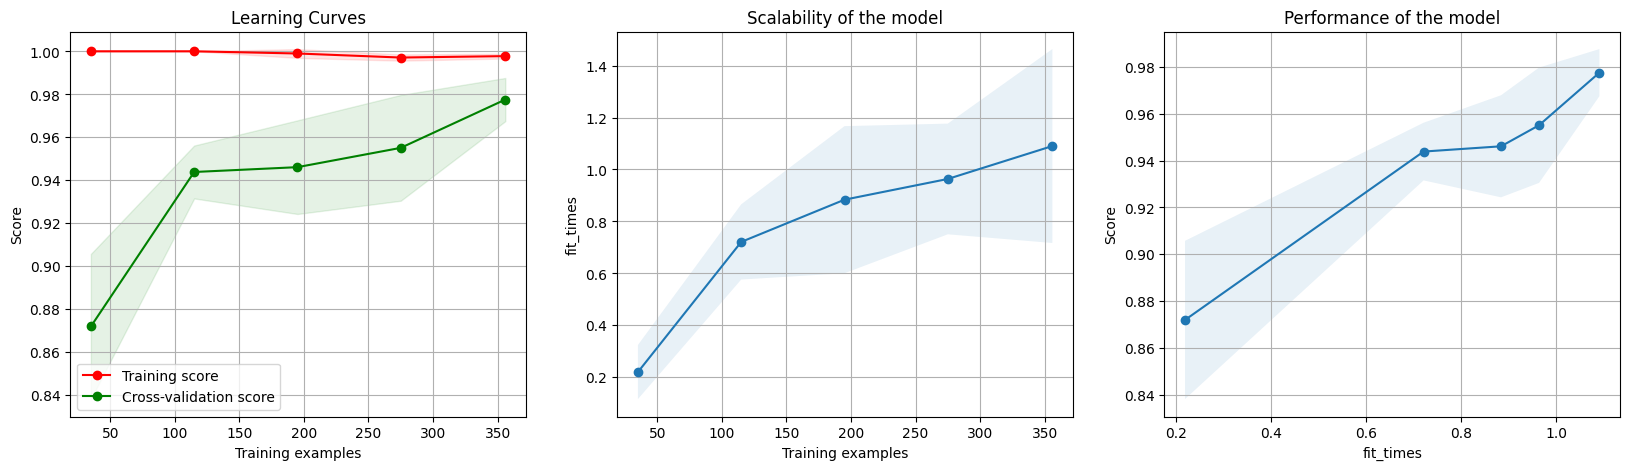

In [51]:
# plot learning curces
plot_learning_curve(grid_classifier_3.best_estimator_, 'Learning Curves',
                    X_train_final, y_train, n_jobs=-1)

In [52]:
X_test.shape

(112,)

In [53]:
# Final Pipeline
def final_pipeline(text):
    # cleaned_text = cp.SpacyPreprocessor(model='en_core_web_sm', batch_size = 1000).transform(text)
    cleaned_text = X_test_cleaned_bow
    basic_cleaned= (X_test_cleaned_basic)
    X_features, feature_names = featurizer.fit_transform(basic_cleaned)
    X_final = pd.concat((pd.DataFrame(cleaned_text, columns=['cleaned_text']),
                         pd.DataFrame(X_features, columns=feature_names)), axis=1)
    best_estimator_pipeline3_round1 =   grid_classifier_3.best_estimator_
    predictions = best_estimator_pipeline3_round1.predict(X_final)
    return predictions


In [54]:
# predicted values for Test data set
y_test_pred = final_pipeline(X_test)

In [55]:
print('\nTest set classification report:\n\n',
      classification_report(y_test, y_test_pred))


Test set classification report:

               precision    recall  f1-score   support

           0       0.97      0.98      0.97        98
           1       0.85      0.79      0.81        14

    accuracy                           0.96       112
   macro avg       0.91      0.88      0.89       112
weighted avg       0.95      0.96      0.95       112



# **Required Submissions:**
1.  Submit two colab/jupyter notebooks
- (analysis with smaller subset and all three pipelines)
- (analysis with bigger subset and only final pipeline)
2. No need to submit the pdf version.
3. **The notebooks and pdf files should have the output.**
4. **Name files as follows : FirstName_file1_hw2, FirstName_file2_h2**